Model training

In [29]:
features = [

'voltage',
'current',
'power_kw',
'temperature_c',
'energy_kwh',
'duration_sec',

'power_deviation',
'energy_deviation',

'rolling_power_mean',
'rolling_power_std',
'rolling_temp_mean',
'rolling_temp_std',

'power_delta',
'temp_delta',
'voltage_delta',

'station_power_deviation',
'station_temp_deviation',

'session_total_energy',
'session_total_duration',

'hour',
'day_of_week',
'is_weekend'

]

print("Number of features:", len(features))

Number of features: 22


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(df[features])

print("Scaled feature shape:", X.shape)

Scaled feature shape: (199566, 22)


In [ ]:
#Estimating contamination for the model 

physics_anomalies = (
    (df['power_kw'] < 0) |
    (df['temperature_c'] < 0) |
    (df['voltage'] < 150) |
    (df['voltage'] > 260)
)

print("Estimated contamination:", physics_anomalies.mean())

Estimated contamination: 0.016305382680416505


In [37]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)

model.fit(X)

df['anomaly'] = model.predict(X)

df['anomaly'] = df['anomaly'].map({1:0, -1:1})

print(df['anomaly'].value_counts())

anomaly
0    195574
1      3992
Name: count, dtype: int64


In [ ]:
# checking physical anomalies and checking how much model was able to detect

physics_anomalies = (
    (df['power_kw'] < 0) |
    (df['temperature_c'] < 0) |
    (df['voltage'] < 150) |
    (df['voltage'] > 260)
)

detected_physics = df[(physics_anomalies) & (df['anomaly'] == 1)]

print("Total physics anomalies:", physics_anomalies.sum())

print("Physics anomalies detected by model:", detected_physics.shape[0])

print("Detection rate:",
      detected_physics.shape[0] / physics_anomalies.sum())

Total physics anomalies: 3254
Physics anomalies detected by model: 1563
Detection rate: 0.4803318992009834


In [ ]:
# Strict physical impossibilities 
cond_power_negative = df['power_kw'] < 0
cond_temp_negative = df['temperature_c'] < 0
cond_energy_negative = df['energy_kwh'] < 0


# Extreme voltage only 
cond_voltage_extreme_low = df['voltage'] < 120
cond_voltage_extreme_high = df['voltage'] > 300


# Extreme temperature only (clear overheating)
cond_temp_extreme_high = df['temperature_c'] > 80


# Extreme power deviation only 
power_dev_threshold = df['power_deviation'].quantile(0.999)
cond_power_dev_extreme = df['power_deviation'] > power_dev_threshold


# Combine relaxed physics anomaly conditions
df['physics_anomaly'] = (
    cond_power_negative |
    cond_temp_negative |
    cond_energy_negative |
    cond_voltage_extreme_low |
    cond_voltage_extreme_high |
    cond_temp_extreme_high |
    cond_power_dev_extreme
).astype(int)


print(df['physics_anomaly'].value_counts())

physics_anomaly
0    196553
1      3013
Name: count, dtype: int64


In [ ]:
#combinig both the result of model trained and physical anomalies calculated

df['final_anomaly'] = ((df['anomaly'] == 1) | (df['physics_anomaly'] == 1)).astype(int)

print(df['final_anomaly'].value_counts())

final_anomaly
0    194430
1      5136
Name: count, dtype: int64


Visualization of detected anomaly

In [ ]:
df['anomaly_score'] = model.decision_function(X)

print(df[['anomaly','anomaly_score']].head())

   anomaly  anomaly_score
0        0       0.132335
1        0       0.106834
2        0       0.119806
3        0       0.076092
4        0       0.114926


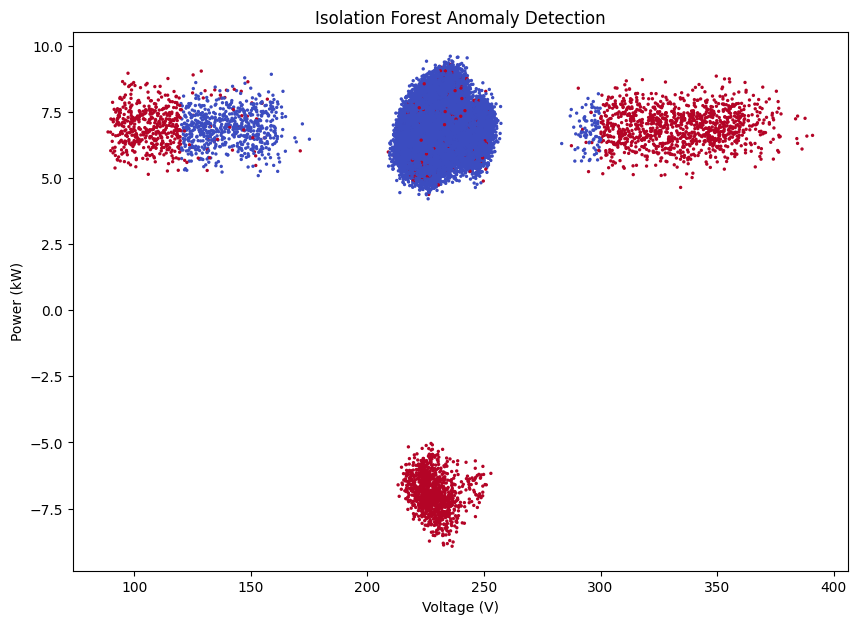

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.scatter(
    df['voltage'],
    df['power_kw'],
    c=df['final_anomaly'],
    cmap='coolwarm',
    s=2
)

plt.xlabel("Voltage (V)")
plt.ylabel("Power (kW)")
plt.title("Isolation Forest Anomaly Detection")



plt.show()

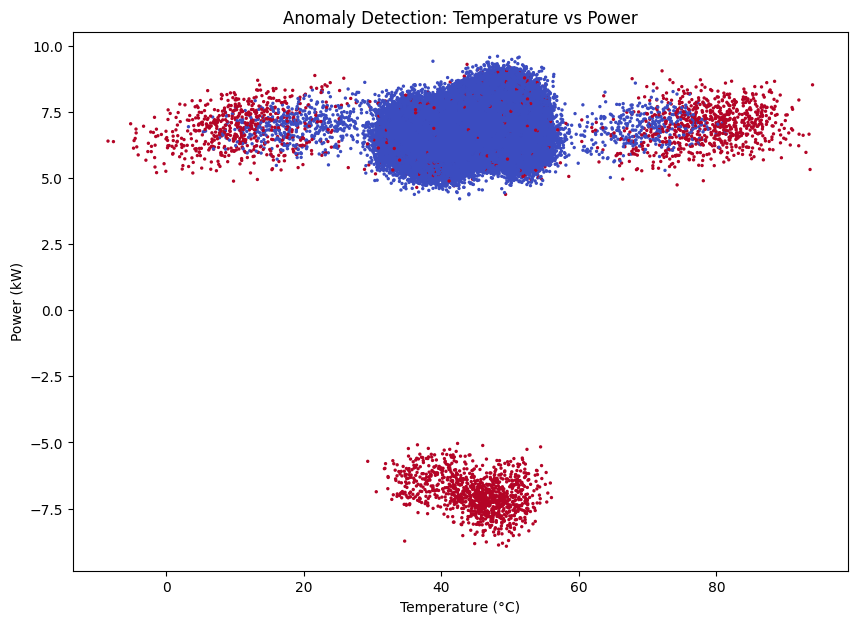

In [ ]:
plt.figure(figsize=(10,7))

plt.scatter(
    df['temperature_c'],
    df['power_kw'],
    c=df['final_anomaly'],
    cmap='coolwarm',
    s=2
)

plt.xlabel("Temperature (°C)")
plt.ylabel("Power (kW)")
plt.title("Anomaly Detection: Temperature vs Power")



plt.show()

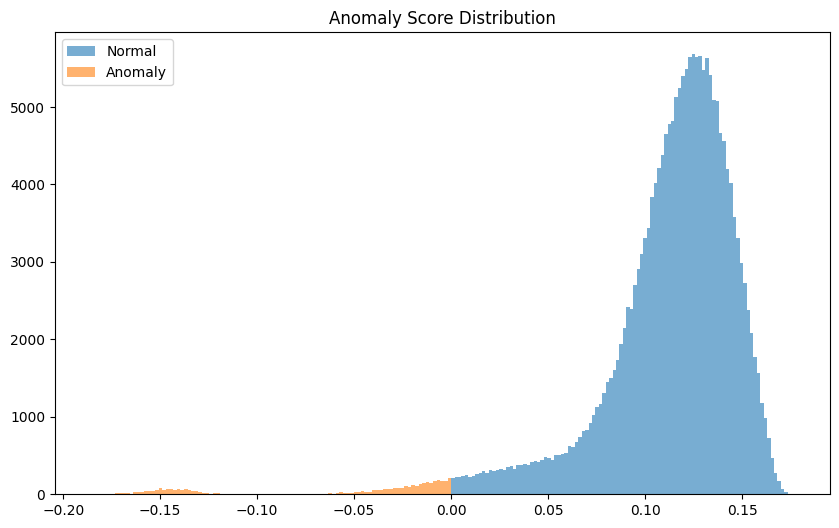

In [56]:
plt.figure(figsize=(10,6))

plt.hist(df[df['anomaly']==0]['anomaly_score'], bins=100, alpha=0.6, label='Normal')

plt.hist(df[df['anomaly']==1]['anomaly_score'], bins=100, alpha=0.6, label='Anomaly')

plt.legend()

plt.title("Anomaly Score Distribution")

plt.show()

Saving model and important features

In [59]:
import pickle

# Save the trained Isolation Forest model
with open("isolation_forest_model.pkl", "wb") as f:
    pickle.dump(model, f)


# Save the trained scaler (contains learned mean and std)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


# Save the feature list (to ensure correct feature order during prediction)
with open("features.pkl", "wb") as f:
    pickle.dump(features, f)


print("Model, scaler, and feature list saved successfully.")

Model, scaler, and feature list saved successfully.
